# Introduction

This is my take on the infamous [Titanic competition](https://www.kaggle.com/competitions/titanic).
We are given two datasets `train` and `test` containing passenger information. The goal is to achieve maximum **accuracy** while predicting if the passengers listed in `test` survived or not. Thus we have a classification problem. 

<div style="width:100%;text-align: center;"> <img align=middle src="https://upload.wikimedia.org/wikipedia/commons/c/c7/Titanic_Structure.jpg" alt="Heat beating" style="height:300px;margin-top:1rem;margin-bottom:1rem;"> </div>

<a id="ToC"></a>
## Table of contents
* [1. Data preparation](#1)  
  * [1.1 Libraries and settings](#1.1)
  * [1.2 Data reading](#1.2)
  * [1.3 Data cleaning](#1.3)
      * [1.3.1 Age](#1.3.1)
      * [1.3.2 Cabin](#1.3.2)
      * [1.3.3 Embarked](#1.3.3)
      * [1.3.4 Fare](#1.3.4)
* [2. Exploratory data analysis (EDA)](#2)
  * [2.1 Univariate analysis](#2.1)
  * [2.2 Multivariate analysis](#2.2)
      * [2.2.1 Correlation matrix](#2.2.1)
      * [2.2.2 Categorical versus continuous features](#2.2.2)
      * [2.2.3 Age versus discrete features](#2.2.3)
      * [2.2.4 Number of siblings or spouses versus number of parents or children](#2.2.4)
* [3. Data modeling](#3)
* [4. Conclusion](#4)

<a id="1"></a>
# 1. Data preparation
[ToC](#ToC) | [Next](#1.1)

In this section relevant libraries and settings used are listed, different datasets are read and missing data is handled according to a preliminary analysis.

<a id="1.1"></a> 
## 1.1 Libraries and settings
[Previous](#1) | [ToC](#ToC) | [Next](#1.2)

All imports and settings used throughout the study are listed in the hidden cell below.

In [1]:
# Dataset paths
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Data wrangling
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Data visualization
!pip install dython --quiet --root-user-action=ignore
from dython.nominal import associations
from dython.nominal import identify_nominal_columns
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from statsmodels.graphics.mosaicplot import mosaic
import seaborn as sns

custom_params = {
    "axes.spines.right": False, 
    "axes.spines.top": False,
    "patch.force_edgecolor": True,
}
sns.set_theme(
    context = "notebook",
    style = 'ticks',
    palette = 'viridis',
    font_scale = 1.25,
    rc = custom_params,
)

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


<a id="1.2"></a> 
## 1.2 Data reading
[Previous](#1.1) | [ToC](#ToC) | [Next](#1.3)

The datasets considered in this study are:
* `train` (from *train.csv*): training set, containing information from passengers that we know they survived;
* `test` (from *test.csv*): test set, containing information from passengers we want to guess if they survived or not.

Another dataset `gender_submission` is only included to exemplify our output format.

The datasets are loaded into their respective dataframes, using their unique `PassengerId` as index.

The `train` dataframe has 891 entries and 12 columns. Some of the columns (`Age`, `Cabin` and `Embarked`) have missing values that will need to be handled. The `test` dataframe contains 418 entries. As expected,`test` has the same columns as `train` except `Survived`. There are missing values in columns `Age`, `Fare` and `Cabin`.

The competition documentation have data dictionaries for the columns `Survived`, `Pclass` and `Embarked`. Mapping corresponding values using suffix `_x` to corresponding column name adds three columns to the `train` dataframe that will later be used to better label our data during EDA.

In [2]:
train = pd.read_csv('/kaggle/input/titanic/train.csv', index_col='PassengerId')
train.name = 'train'

test = pd.read_csv('/kaggle/input/titanic/test.csv', index_col='PassengerId')
test.name = 'test'

gender_submission = pd.read_csv('/kaggle/input/titanic/gender_submission.csv', index_col='PassengerId')
gender_submission.name = 'gender submission'

both = [train, test] # Useful when needing to call or transform both datasets

def dataframe_summary():
    "Prints a summary for both datasets"
    for df in both:
        print(f"'{df.name}' dataframe summary:")
        print(f"Is '{df.name}' dataframe index unique? {df.index.is_unique}")
        df.info(memory_usage=False)
        print('\n')
dataframe_summary()
    
# Data dictionaries, useful when visualizing data
data_dictionaries = {
    'Survived': {0:'Perished', 1:'Survived'},
    'Pclass': {1:'1st', 2:'2nd', 3:'3rd'},
    'Embarked': {'C':'Cherbourg', 'Q':'Queenstown', 'S':'Southampton'}
}

# Apply data dictionary to 'train' to facilitate understanding
for column, dictionary in data_dictionaries.items():
    train[column+'_x'] = train.loc[~train[column].isnull(), column].apply(lambda x: dictionary[x])
    
print("'train' dataframe:")
train.head()

'train' dataframe summary:
Is 'train' dataframe index unique? True
<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)

'test' dataframe summary:
Is 'test' dataframe index unique? True
<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null  

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived_x,Pclass_x,Embarked_x
PassengerId,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Perished,3rd,Southampton
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Survived,1st,Cherbourg
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Survived,3rd,Southampton
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Survived,1st,Southampton
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Perished,3rd,Southampton


<a id="1.3"></a> 
## 1.3 Data cleaning
[Previous](#1.2) | [ToC](#ToC) | [Next](#1.3.1)

We have four columns that have missing values in either dataframe. For each column we will make a preliminary exploration and decide how we will handle these values in both dataframes. We will use solely information from `train` dataframe to avoid data leakage.

The hidden cell below contains some helper functions that will help us summarize data, replace missing values and plot histograms and boxplots during data cleaning stage.

In [3]:
def summarize(column_name: str) -> None:
    """
    Given a column name, print column null count for both dataframes.
    Then give a statistical summary for this column on train dataframe
    """
    for df in both:
        print(
            f"There are {df[column_name].isnull().sum()}/{df.shape[0]} " 
            f"null values in column '{column_name}' of '{df.name}' dataframe."
        )
    print(f"\nStatistical summary for '{column_name}' series in 'train' dataframe:")
    print(train[column_name].describe(), '\n')
    
def histogram_and_boxplot(column_name: str, ceiling=float('inf')) -> None:
    """
    Given a column name, return a grid showing a histogram for total count distribution
    and a boxplot highlighting median and outliers for passengers divided by survival.
    
    If a custom ceiling value is given, our plots will consider the fraction of the data
    up to ceiling value.
    """
    # Set figure grid
    fig, axes = plt.subplots(
        nrows = 2,
        ncols = 1, 
        sharex = True, 
        figsize = (10,6),
        gridspec_kw = dict(height_ratios=[2,1])
    )
    # Set suptitle to right align and position it in the top right corner
    title = f"{column_name} distribution in training data"
    title += f' (<= {ceiling})' if ceiling != float('inf') else ''
    fig.suptitle(
        title,
        ha = 'right',
        x = 0.95,
        y = 1,
    )
    if ceiling != float('inf'):
        plt.setp(axes, xlim =(0, ceiling))
        
    # Use tight layout to plot more cleanly
    fig.tight_layout()
    fig.subplots_adjust(top=1)
    
    # Get non NA points for column_name
    train_dropna = train[train[column_name].notnull()]
    
    # Select custom pallete, width and color for lines
    palette = dict(Perished='lightcoral', Survived='lightgreen')
    edgecolor = 'k'
    linewidth = 1
    
    # Boxplot
    boxes = sns.boxplot(
        data = train_dropna,
        x = column_name,
        y = 'Survived_x',
        hue = 'Survived_x',
        ax = axes[1],
        saturation = 1,
        palette = palette,
        linewidth = linewidth,
        dodge = False,
        boxprops = dict(edgecolor=edgecolor),
        medianprops = dict(color=edgecolor),
        whiskerprops = dict(color=edgecolor),
        flierprops = dict(markerfacecolor=edgecolor),
        capprops = dict(color=edgecolor),
    )
    # Boxpot style options
    axes[1].get_xaxis().set_visible(False)
    axes[1].get_yaxis().set_visible(False)
    axes[1].spines[['left', 'bottom']].set_visible(False)
    axes[1].legend([],[],frameon=False) # Remove legend
    
    # Annotate median value according to survivability
    medians = train_dropna.groupby('Survived_x')[column_name].median()
    for i in range(len(medians)):
        boxes.annotate(
            f' {medians[i]:.1f}',
            xy = (medians[i], i),
            ha = 'left',
            va = 'center',
        )    
    # Get legend information to be transported to histogram and format its line
    handles, labels = axes[1].get_legend_handles_labels()
    for handle in handles:
        handle.set_edgecolor(edgecolor)
        handle.set_linewidth(1)
    
    # Histogram plot
    sns.histplot(
        data = train_dropna,
        x = column_name,
        hue = 'Survived_x',
        multiple = 'stack',
        stat = 'count',
        ax = axes[0],
        edgecolor = edgecolor,
        alpha = 1,
        palette = palette,
    )
    axes[0].get_yaxis().set_visible(False)
    axes[0].spines[['left']].set_visible(False)
    axes[0].tick_params(labelbottom=True)
    
    # Annotate median on histogram
    median = train_dropna[column_name].median()
    axes[0].axvline(
        x = median,
        c = edgecolor,
        label = 'Median',
        ls = 'dashed',
        lw = 1.25,
        ymax = 0.95,
    )
    axes[0].text(
        x = median,
        y = 0.95,
        s = f' {median:.1f}',
        ha = 'left',
        va = 'top',
        transform=axes[0].get_xaxis_transform(),
    )
    # Get median line information and updata label
    h, l = axes[0].get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)
    axes[0].legend(
        handles, labels,
        bbox_to_anchor = (1, 0.9), 
        frameon = False,
        edgecolor = edgecolor,
    )
    fig.show()
    
def replace_na_by_median(column_name:str) -> None:
    "Replaces missing values in given column using 'train' median."
    for df in both:
        df.loc[df[column_name].isnull(), [column_name]] = train[column_name].median()

<a id="1.3.1"></a>
### 1.3.1 Age
[Previous](#1.3) | [ToC](#ToC) | [Next](#1.3.2)

In order to study `Age` distribution we consider its summary statistics and two plots. The first plot is a stacked histogram and the second is a boxplot. It might be interesting to evaluate how `Age` is distributed if we were to divided the entries into groups of those who survived and those who perished.

The `Age` stacked histogram shows a roughly bimodal normal distribution slightly right-skewed.
The boxplot evidentiate that the median age remains 28 regardless of the survivability group. It also highlights the outliers are concentrated among the oldest passengers for each group.

In order to preserve the distribution shape, we can use the `train` median as a fill value for missing `Age` values. We are using the median and not the mean because the median is a more reliable center measure when the distribution is skewed.

There are 177/891 null values in column 'Age' of 'train' dataframe.
There are 86/418 null values in column 'Age' of 'test' dataframe.

Statistical summary for 'Age' series in 'train' dataframe:
count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64 



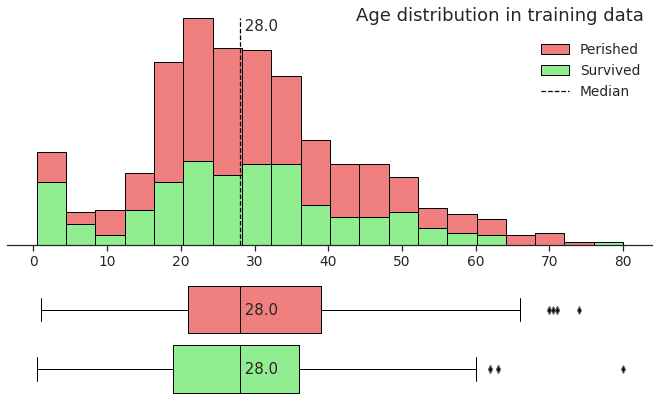

In [4]:
summarize('Age')
histogram_and_boxplot('Age')
replace_na_by_median('Age')

<a id="1.3.2"></a>
### 1.3.2 Cabin
[Previous](#1.3.1) | [ToC](#ToC) | [Next](#1.3.3)

The majority of values in `Cabin` column is missing in both dataframes. Two observations can be made:
1. If we grouped missing values in a category (say `missing`), this category would represent the majority of cases. 
2. Looking at the frequency of unique non-missing values we see they are too numerous and each have a very small frequency. The most frequent unique values have a frequency of 4.

An approach could be consider missing values as a category and transform `Cabin` into frequncy categories (frequent/infrequent). But observations 1 and 2 combined would result in a very biased and noninformative feature.

Thus, we opt not to include `Cabin` information in our study.

In [5]:
summarize('Cabin')
for df in both:
    df.drop('Cabin', axis='columns', inplace=True)

There are 687/891 null values in column 'Cabin' of 'train' dataframe.
There are 327/418 null values in column 'Cabin' of 'test' dataframe.

Statistical summary for 'Cabin' series in 'train' dataframe:
count         204
unique        147
top       B96 B98
freq            4
Name: Cabin, dtype: object 



<a id="1.3.3"></a>
### 1.3.3 Embarked
[Previous](#1.3.2) | [ToC](#ToC) | [Next](#1.3.4)

There are only 2 missing values in `train` dataframe. As this is a very small portion of data, we choose to ignore these two entries moving forward.

In [6]:
summarize('Embarked')
train.dropna(subset=['Embarked'], inplace=True)

There are 2/891 null values in column 'Embarked' of 'train' dataframe.
There are 0/418 null values in column 'Embarked' of 'test' dataframe.

Statistical summary for 'Embarked' series in 'train' dataframe:
count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object 



<a id="1.3.4"></a>
### 1.3.4 Fare
[Previous](#1.3.3) | [ToC](#ToC) | [Next](#2)

There's a single missing `Fare` value in `test` dataframe. Despite the maximum `Fare` value being 512, in order to better analyse the distribution shape, we opt to partialy plot fares up to 125. We have outliers going up to 512, but our interval of interest concentrates all major .

The partial `Fare` stacked histogram shows a unimodal distribution heavily right-skewed.
The boxplot evidentiate that the distribution of passengers who perished compared to those who survived have a smaller median and a more concentrated IQR.

We will treat the missing `Fare` value in `test` as we did the missing `Age` values, replacing missing values with the median of all passengers.

There are 0/889 null values in column 'Fare' of 'train' dataframe.
There are 1/418 null values in column 'Fare' of 'test' dataframe.

Statistical summary for 'Fare' series in 'train' dataframe:
count    889.000000
mean      32.096681
std       49.697504
min        0.000000
25%        7.895800
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64 



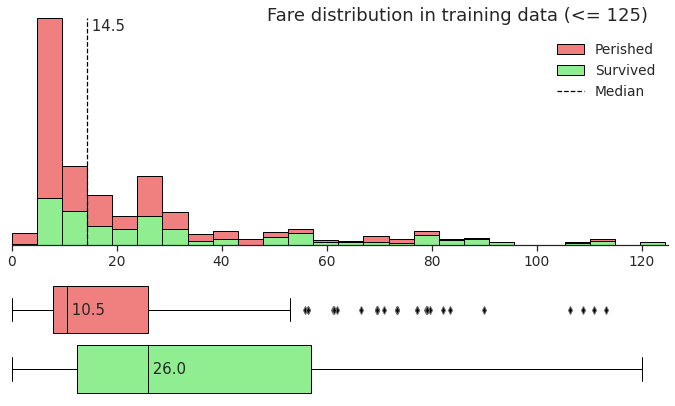

In [7]:
summarize('Fare')
histogram_and_boxplot('Fare', 125)
replace_na_by_median('Fare')

<a id="2"></a>
# 2. Exploratory data analysis (EDA)
[Previous](#1.3.4) | [ToC](#ToC) | [Next](#2.1)

From `train` dataset we make a primary selection of 7 features besides our prediction target `Survived`. In order to make EDA as readable as possible we are going to use the translated features with suffix `_x`. For modeling purposes we will use their original values.

In the following sections we are going to make univariate and multivariate analysis. We are going to discuss any detection of associated features.

In [8]:
primary_features = ['Sex', 'Age', 'Embarked', 'SibSp', 'Parch', 'Fare', 'Pclass']
primary_target = ['Survived']

categorical = ['Sex', 'Embarked','Pclass']
continuous = ['Age', 'Fare']
discrete = ['SibSp', 'Parch']

# Stratify both Age and Fare in order to analyse them
train['Age_x'] = pd.cut(
    train.Age, 
    list(range(0,90,10)),
    labels = [f'{i}0-{i+1}0' for i in range(8)],
)
train['Fare_x'] = pd.qcut(
    train.Fare, 
    q = 4, 
    labels = ['Q1', 'Q2', 'Q3', 'Q4'],
)

train[primary_target + primary_features].head()

,Survived,Sex,Age,Embarked,SibSp,Parch,Fare,Pclass
PassengerId,,,,,,,,
1,0,male,22.0,S,1,0,7.2500,3
2,1,female,38.0,C,1,0,71.2833,1
3,1,female,26.0,S,0,0,7.9250,3
4,1,female,35.0,S,1,0,53.1000,1
5,0,male,35.0,S,0,0,8.0500,3


The following hidden cell contains a dictionary that controls plot settings.

In [9]:
# Feature: (Title, Use translated column, Prefered order, Y-axis limit)
settings = {
    'Sex': ('Sex', False, ['female', 'male'], None),
    'Age': ('Age', True, None, None),
    'Pclass': ('Passenger class (Pclass)', True, ['3rd', '2nd', '1st'], None),
    'SibSp': ('Number of siblings or spouses (SibSp)', False, None, None),
    'Parch': ('Number of parents or children (Parch)', False, None, None),
    'Fare': ('Fare', True, None, 200), 
    'Embarked': ('Port of embarkation (Embarked)', False, None, None),
    'Survived': ('Survived', False, None, None)
} 

<a id="2.1"></a> 
## 2.1 Univariate analysis
[Previous](#2) | [ToC](#ToC) | [Next](#2.2)

We analyse the survivability ratio for each category in every feature by taking the mean `Survived` for that specific subset. Our initial selection of features contain categorical and numerical features. The numerical continuous features `Age` and `Fare` need to be stratified. The numerical discrete features such as `SibSp` assume a reasonably small number of different values and do not need to be stratified.

Some observations can be made:
* `Sex`: Female passengers have a substantialy higher (0.74) survivability rate than their male counterparts (0.19), suggesting a strong association with survival.
* `Age`: Stratifying passenger age into intervals of 10 years, we can observe that there is a general trend that implies that the older a passenger was, the less likely it was to survive.
* `Embarked` (Port of embarkation): Passengers that embarked from the Cherbourg port had a substantialy higher survivability ratio (0.55) than passengers that embarked from Southampton (0.34) or Queenstown (0.39) ports.
* `SibSp` (Number of siblings or spouses): general trend indicating that the higher `SibSp`, the less likely was a passenger to survive. Exception made for having no `SibSp`.
* `Parch` (Number of parents or children): passengers with `Parch` from 1 to 3 have a substantialy higher survivability ratio than passengers with 0 `Parch` (0.34). From `Parch` 4 onwards, the ratio drops to levels worse than `Parch` 0.
* `Fare`: Stratifying into quantiles where Q1 represents passengers that paid the lowest fare and Q4 the highest, we observe a general trend that the higher the fare, the more likely a passenger was to survive.
* `Pclass`: lower class passengers were more unlikely to survive than higher class passengers.

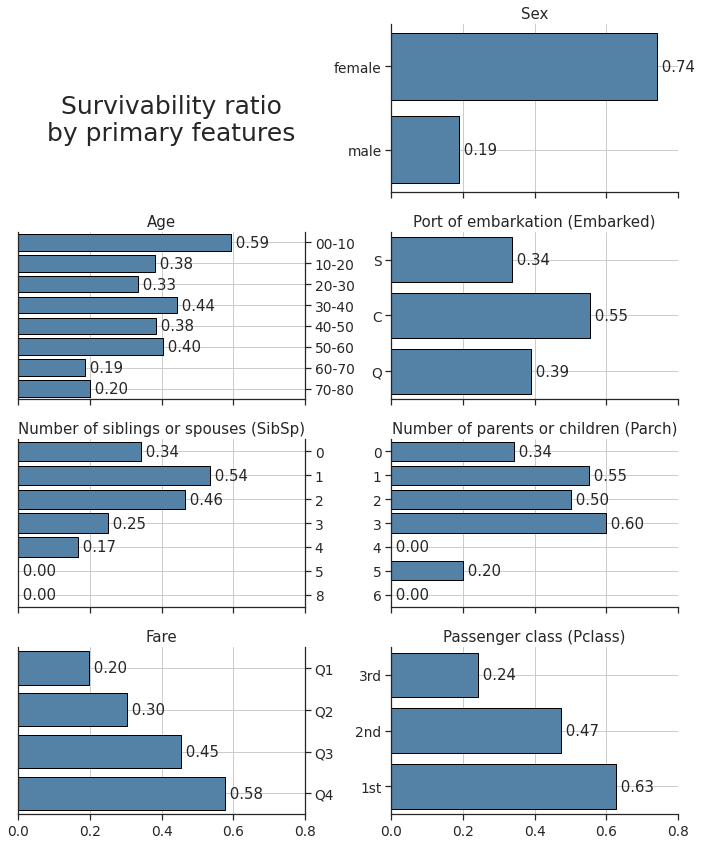

In [10]:
def barplot(column_name: str, ax, right_side) -> None:
    'Returns survivability rate barplots for different features'
    
    # Choose if we are going to use the translated column
    y = column_name
    if settings[column_name][1]:
        y += '_x'
    
    sns.barplot(
        ax = ax,
        data = train,
        x = 'Survived',
        y = y,
        order = settings[column_name][2],
        color = 'steelblue',
        edgecolor = 'k',
        orient = 'h',
        ci = None,
    ).set(
        title = settings[column_name][0],
        xlabel = None,
        ylabel = None,
    )
    ax.bar_label(
        ax.containers[-1], 
        fmt=' %.2f', 
        label_type='edge'
    )
    
    if right_side: # Rotate y labels and axis for odd numbered axis
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position("right")
        ax.spines[['right']].set_visible(True)
    
    ax.grid()
    plt.tight_layout()

def univariate():
    'Returns survivability rate barplots for different features'   
    
    # Set figure grid
    fig, axes = plt.subplots(
        nrows = 4,
        ncols = 2, 
        sharex = True, 
        figsize = (10,12),
    )
    axes = axes.flatten() # Make axes array one dimensional
    axes[0].set_xlim([0, 0.8])
    fig.delaxes(axes[0]) # Make space for title

    # Title
    fig.text(
        x = 0.25, 
        y = 0.85,
        s = "Survivability ratio\nby primary features",
        ha="center", 
        va="center", 
        size=25,
    )

    # Fill grid with primary features univariate plots
    for i, feature in enumerate(primary_features):
        barplot(feature, axes[i+1], bool(i % 2))
        
univariate()

<a id="2.2"></a> 
## 2.2 Multivariate analysis
[Previous](#2.1) | [ToC](#ToC) | [Next](#2.2.1)

We generate a correlation matrix to help us identify the strongest associations between features. we generate visualizations for some of these associations to help and explore them further. 

<a id="2.2.1"></a> 
### 2.2.1 Correlation matrix
[Previous](#2.2) | [ToC](#ToC) | [Next](#2.2.2)

The train data set contains heterogeneous data. We will create a correlation matrix by using the [associations function from dython library.](https://shakedzy.xyz/dython/modules/nominal/#associations) It uses different strategies to calculate feature association according to the feature types:
- Continuous-continuous cases: [Pearson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient), 
- Categorical-continuous cases: [Correlation ratio](https://en.wikipedia.org/wiki/Correlation_ratio#:~:text=In%20statistics%2C%20the%20correlation%20ratio,representing%20these%20types%20of%20variation.), 
- Categorical-categorical cases: [Cramer’s V](https://www.statstest.com/cramers-v-2/).

It's important to note that we traverse `Pclass` in the following order: 1st, 2nd then 3rd, i.e. decreasing social class status.

Some observations can be made from the correlation matrix:
* Target `Survived`: As stated in univariate analysis, there is a strong association between survivability and `Sex`. It's also significant the association with features `Fare`,`Embarked` and `Pclass`, although the last is negative because of the feature order. Associations with the remainder features `Age`, `SibSp` and `Parch` are weak.
* The number of parents or children `Parch` and `Fare` seems to be associated with `Sex`.
* `Age` is inversely associated with number of siblings or spouses `SibSp`, `Parch` and `Pclass`. 
* Port of embarkation `Embarked` is associated with passenger class and fare.
* `SibSp` and `Parch`: these features are highly associated, possibly indicating that passengers either traveled alone or acompanied with many family members.
* `Pclass` and `Fare`: strongly associated, the better the social class, the higher the `Fare`

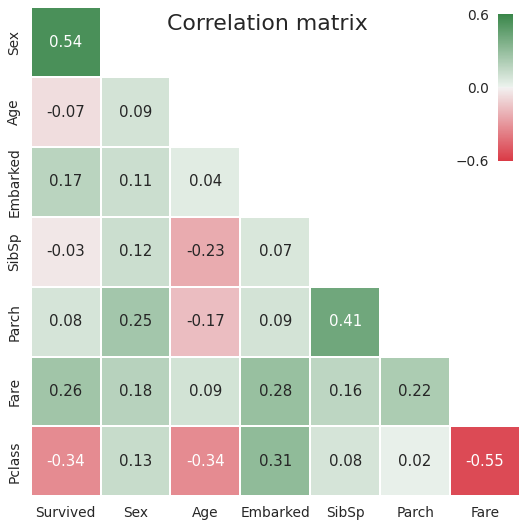

In [11]:
def correlation_matrix(features):
    "Prints correlation matrix for selected features, even categorical"
    corr = associations(
        dataset = train[features],
        plot = False,
        compute_only = True,
    )['corr'];

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    fig, ax = plt.subplots(figsize=(9, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(10, 133, as_cmap=True)

    # Remove first row and column, they would be empty
    corr = corr.iloc[1:,:-1]
    mask = mask[1:,:-1]

    # Draw the heatmap with the mask and correct aspect ratio
    ax = sns.heatmap(
        data = corr, 
        mask = mask, 
        cmap = cmap,
        fmt = '.2f',
        cbar = False,
        vmax = .6,
        vmin = -.6,
        center = 0,
        annot = True,
        square = True,
        linewidths = 2,
        cbar_kws = {"shrink": .5}
    )
    ax.tick_params(left=False, bottom=False)

    # Title
    fig.text(
        x = .5, 
        y = .87,
        s = "Correlation matrix",
        ha="center", 
        va="top", 
        size=22,
    );

    # Custom colorbar axis
    cbaxes = inset_axes(
        ax,
        width="3%", 
        height="30%", 
        loc=1
    )

    # Populate colorbar
    clb = plt.colorbar(
        mappable = ax.collections[0],
        cax = cbaxes,
        ticks = [-.6,0,.6],
        orientation = 'vertical',
        drawedges = False,
    )

    # Remove outline, rotate tick labels and remove ticks
    clb.outline.set_visible(False)
    cbaxes.yaxis.tick_left()
    cbaxes.tick_params(left=False, bottom=False)

correlation_matrix(primary_target+primary_features)

<a id="2.2.2"></a> 
### 2.2.2 Categorical versus continuous features
[Previous](#2.2.1) | [ToC](#ToC) | [Next](#2.2.3)

We can generate a violin plot to explore how categorical features `Sex`, `Embarked` and `Pclass` relate to continuous features `Age` and `Fare`. From the graph we can extract that:
* `Age` and `Sex`: distributions roughly the same, but the older passengers tended to be male.
* `Age` and `Embarked`: passengers that embarked at Southampton and Cherbourg ports had an evenly distributed survivability rate regardless of their age. Passengers that embarked at Queenstown and survived are concentrated around the age median.
* `Age` and `Pclass`: people that belonged to higher social classes tended to be slightly older.
* `Fare` and `Sex`: roughly the same survivability distribution regardless of sex.
* `Fare` and `Embarked`: passengers paid higher fares at Cherbourg port, followed by Southampton and lower fares at Queenstown. 
* `Fare` and `Pclass`: as previously shown by correlation matrix and intuitively, passengers belonging to a higher social class paid higher fares.

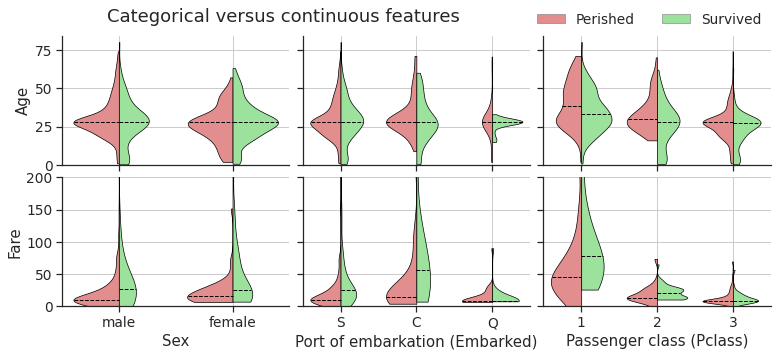

In [12]:
def categorical_vs_continuous_plot():
    "Plots a violin plot for each pair of categorical and continuous features."
    
    g = sns.PairGrid(
        data = train, 
        hue = 'Survived_x',
        hue_order = ['Perished', 'Survived'],
        x_vars = categorical,
        y_vars = continuous,
        palette = dict(Perished='lightcoral', Survived='lightgreen'),
        aspect = 1.5
    )
    g.map(
        sns.violinplot, 
        split = True, 
        edgecolor = 'k', 
        linewidth = 1,
        inner = 'quartiles',
        linestyle = ':',
        orient = 'v',
        cut = 0,
    )
    # Title and legend
    g.tight_layout()
    g.fig.suptitle(
        t = 'Categorical versus continuous features', 
        x = 0.13,
        ha = 'left',
    )
    g.fig.subplots_adjust(top=0.9)
    g.add_legend(
        title = '', 
        loc = 'upper left',
        ncol = 2,
        bbox_to_anchor=(.53, 1),
    );

    # Additional tweaks in matplotlib
    for ax in g.fig.axes:
        ax.grid() # Add grid to the plot
        
        # Get information from settings according to axis labels
        x_settings = settings[ax.get_xlabel()]
        y_settings = settings[ax.get_ylabel()]
        
        # Customize limits according to settings
        ax.set_ylim(bottom=0)
        if y_settings[3]:
            ax.set_ylim(top=y_settings[3])
        
        # Change labels
        ax.set_xlabel(x_settings[0])
        ax.set_ylabel(y_settings[0])
        
        # Change violinplot contour to make it more visible
        for container in ax.collections:
            container.set_edgecolor('k')
            container.set_linewidth(.7)
        
        # Keep only median lines
        for i, l in enumerate(ax.lines):
            if not (i%3-1): # Style median line
                l.set(linestyle = '--', color = 'k')
            else:
                l.set(visible = False) # Remove IQR
                
categorical_vs_continuous_plot()

<a id="2.2.3"></a> 
### 2.2.3 Age versus discrete features
[Previous](#2.2.2) | [ToC](#ToC) | [Next](#2.2.4)

* The dispersion of `Age` distribution decreases as we increase the number of siblings or spouses `SibSp`. Meaning that we can expect that the more accompanied by siblings or spouses a passenger was, the younger this passenger was.
* The same can be said to the number of parents or children up to 3. The more accompanied by parents or children, the younger this passenger was.

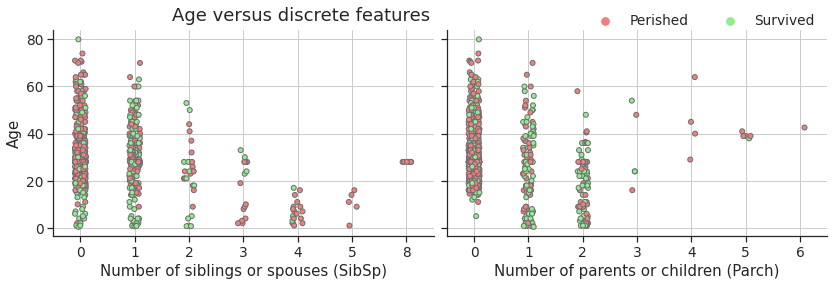

In [13]:
def continuous_vs_discrete(continuous, discrete):
    ""
    
    g = sns.PairGrid(
        data = train, 
        hue = 'Survived_x',
        hue_order = ['Perished', 'Survived'],
        x_vars = discrete,
        y_vars = 'Age',
        palette = dict(Perished='lightcoral', Survived='lightgreen'),
        height = 4,
        aspect = 1.5,
    )
    g.map(
        sns.stripplot, 
        linewidth = 1,
        dodge = False,
    )
    # Title and legend
    g.tight_layout()
    g.fig.suptitle(
        t = 'Age versus discrete features', 
        x = 0.18,
        ha = 'left',
    )
    g.fig.subplots_adjust(top=0.9)
    g.add_legend(
        title = '', 
        loc = 'upper left',
        ncol = 2,
        bbox_to_anchor=(.55, 1),
    );

    # Additional tweaks in matplotlib
    for ax in g.fig.axes:
        ax.grid() # Add grid to the plot

        # Get information from settings according to axis labels
        x_settings = settings[ax.get_xlabel()]
        y_settings = settings[ax.get_ylabel()]

        # Change labels
        ax.set_xlabel(x_settings[0])
        ax.set_ylabel(y_settings[0])
        
continuous_vs_discrete('Age', discrete)

<a id="2.2.4"></a> 
### 2.2.4 Number of siblings or spouses versus number of parents or children
[Previous](#2.2.3) | [ToC](#ToC) | [Next](#3)

For both `SibSp` and `Parch` we create an correspondent `_x` variant that aggregates infrequent data points. From the mosaic plot using these variables we observe that:
* The vast majority of passengers were not accompanied by close family members.
* If a passenger was accompanied by a family member belonging to either `SibSp` or `Parch` groups, the more likely it was that this passenger was accompanied by a family member belonging to the complementary group, as evidentiated by the decreasing height of blue rectangles reserved for passengers not accompanied by parents or children as the number of siblings or spouses increases.

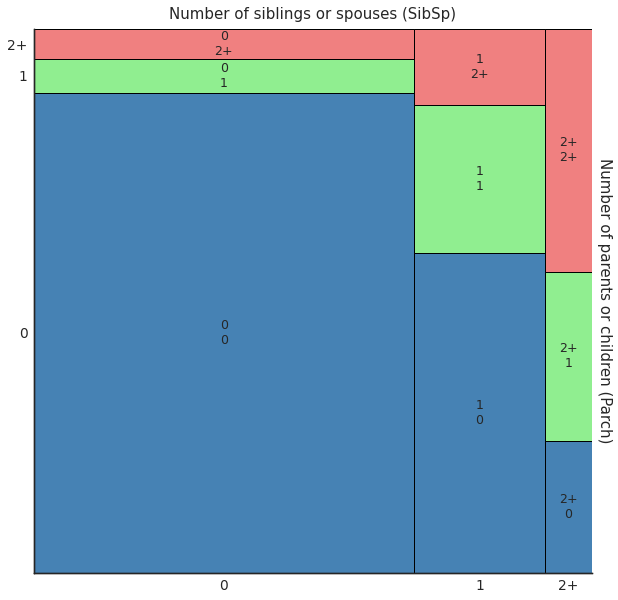

In [14]:
def mosaic_plot(feature_a, feature_b, threshold=2):
    "Create a mosaic plot for two discrete features and consider a threshold to aggregate infrequent data"
    
    def aggregate_infrequent(value):
        'Create aggregated feature from a numerical feature'
        
        if value >= threshold:
            return str(threshold) + '+'
        return str(value)

    # Aggregate features according to threshold
    for feature in [feature_a, feature_b]:
        train[feature + '_x'] = train[feature].apply(aggregate_infrequent)

    def rectangle_properties(rectangle):
        "Set colors according to y labels"
        
        if rectangle[1] == '0':
            color = 'steelblue'
        elif rectangle[1] == '1':
            color = 'lightgreen'
        else:
            color = 'lightcoral'
            
        return {
            'facecolor': color,
            'linewidth': 1,
            'edgecolor': 'k',
        }
    
    # Create mosaic plot
    fig, rects = mosaic(
        data = train.sort_values([feature_a, feature_b]),
        index = [feature_a+'_x', feature_b+'_x'],
        gap = 0,
        properties = rectangle_properties,
    )
    # Figure parameters 
    fig.set_size_inches(10, 10, forward=True)
    fig.axes[0].tick_params(
        left = False,
        bottom = False,
        pad = 0,
    )
    # Label text and position
    ax = fig.axes[0]    
    ax.set_xlabel(settings[feature_a][0], labelpad=10)
    ax.xaxis.set_label_position('top')
    ax.set_ylabel(settings[feature_b][0], rotation=270, labelpad=20)
    ax.yaxis.set_label_position('right')
    
mosaic_plot('SibSp', 'Parch')

<a id="3"></a>
# 3. Data modeling
[Previous](#2.2.4) | [ToC](#ToC) | [Next](#4)

WIP

<a id="4"></a>
# 4. Conclusion
[Previous](#3) | [ToC](#ToC) | [Next](#4)

WIP